# Pokemon Combat Prediction
## Name: HOO YEE TORNG (P101447)

### 1.0 Data Preprocessing
3 datasets are imported from "dataset" folder and converted to pandas dataframe format

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from model.StratifiedShuffleSplitModel import StratifiedShuffleSplitModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
sns.set(style="darkgrid")

#### 1.1 Constructure Training Data
2 Sets of datasets are download from Kaggle and DataWorld. One dataset is the Pokemon Stat and another dataset is the Combat result. A single master dataset with combat history (as training data) and Pokemon Stat need to be created.

In [2]:
#####################################################
## SHARE FUNCTION
#####################################################

def check_column_for_null(data):
    count = 0
    for column in data.columns:
        mask = data[column].isna()
        selected_col = data.loc[mask]
        if selected_col.shape[0] > 0:
            count+=1
            print("'{}' : {} row(s)".format(column, str(selected_col.shape[0])))
    if count <= 0:
        print("- [LOG] No Null Value")
            
def create_pearson_heat_map(data_name, data, method):
    file_path = "output/descriptive/heatmap_{}_{}_report.png".format(method, data_name)
    corr_mat = data.corr(method=method)
    fig, ax = plt.subplots(figsize=(14, 15))
    cbar_kws = {'orientation': "horizontal", 'pad': 0.05, 'aspect': 50}
    sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax, cmap="YlGnBu", fmt='.2f', linewidths=.3)
    plt.suptitle("{} Correlation Heatmap\n".format(method), size = 12);
    plt.savefig(file_path, dpi=500)
    plt.show()
    print("- [LOG] Output also save to " + file_path)
    
def create_pair_plot(data, x_feature, y_feature):
    file_path = "output/descriptive/pairplot_{}_report.png".format(x_feature)
    sns.pairplot(data, x_vars=[x_feature], y_vars=y_feature, height=5, aspect=1, kind='reg')
    plt.suptitle("Feature '{}' v.s. '{}' \n".format(x_feature, y_feature), size = 12);
    plt.savefig(file_path, dpi=500)
    plt.show()
    print("- [LOG] Output also save to " + file_path)


##### 1.1.1 Pokemon Stat Dataset
- Use the Mask function to retrieve the number of null cells for each features
- There are total 4 features with nulll values
    - 'weight_kg' and 'height_m' will be replaced with average value
    - 'pokemon_type_2' and 'percentage_male' is removed from the dataset

In [3]:
pokemon_stat = pd.read_csv('dataset/master_pokemons.csv')

## CHECK NULL VALUE PER COLUMNS
check_column_for_null(pokemon_stat)

# FILL weight_kg WITH AVERAGE VALUE
pokemon_stat['weight_kg'] = pokemon_stat['weight_kg'].astype(float)
pokemon_stat['weight_kg'].fillna((pokemon_stat['weight_kg'].mean()), inplace=True)

# FILL height_m WITH AVERAGE VALUE
pokemon_stat['height_m'] = pokemon_stat['height_m'].astype(float)
pokemon_stat['height_m'].fillna((pokemon_stat['height_m'].mean()), inplace=True)

# DROP 
pokemon_stat = pokemon_stat.drop(['pokemon_type_2'], axis=1)
pokemon_stat = pokemon_stat.drop(['percentage_male'], axis=1)
pokemon_stat = pokemon_stat.drop(['base_total'], axis=1)

print("\n-- Pokemon Stat ----------------- ")
print(pokemon_stat.shape)
print("\n")

'pokemon_type_2' : 386 row(s)
'percentage_male' : 99 row(s)
'height_m' : 20 row(s)
'weight_kg' : 20 row(s)

-- Pokemon Stat ----------------- 
(800, 37)




##### 1.1.2 Pokemon Combat Dataset
Pokemon Combat dataset as 3 features (First_Pokemon, Second_Pokemon and Winner). In order to make the prediction by considering the Pokemon Stat as well. Following code to create a new dataset with the combinsation of the stat and combat result

In [4]:
#####################################################
## SHARE FUNCTION
#####################################################


def structure_first_player_dataframe(data, data_stat):
    
    data_stat = data_stat.rename(columns={
        'pokemon_code':'First_pokemon',
        'pokemon_name':'first_pokemon_name',
        'pokemon_type_1':'first_pokemon_type_1', 
        'pokemon_type_2':'first_pokemon_type_2',
        'high_point':'first_high_point', 
        'attack_force':'first_attack_force',
        'defense_point':'first_defense_point', 
        'special_attack_force':'first_special_attack_force',
        'special_defense_point':'first_special_defense_point', 
        'speed':'first_speed', 
        'generation':'first_generation',
        'legendary':'first_legendary', 
        'against_bug':'first_against_bug',
        'against_dark':'first_against_dark', 
        'against_dragon':'first_against_dragon',
        'against_electric':'first_against_electric', 
        'against_fairy':'first_against_fairy',
        'against_fight':'first_against_fight', 
        'against_fire':'first_against_fire',
        'against_flying':'first_against_flying', 
        'against_ghost':'first_against_ghost',
        'against_grass':'first_against_grass', 
        'against_ground':'first_against_ground',
        'against_ice':'first_against_ice', 
        'against_normal':'first_against_normal',
        'against_poison':'first_against_poison', 
        'against_psychic':'first_against_psychic',
        'against_rock':'first_against_rock', 
        'against_steel':'first_against_steel',
        'against_water':'first_against_water', 
        'base_egg_steps':'first_base_egg_steps',
        'base_happiness':'first_base_happiness', 
        'base_total':'first_base_total',
        'capture_rate':'first_capture_rate', 
        'classfication':'first_classfication',
        'percentage_male':'first_percentage_male', 
        'experience_growth':'first_experience_growth',
        'height_m':'first_height_m', 
        'weight_kg':'first_weight_kg',
        'pokedex_number':'first_pokedex_number'
    })
    
    data = data.join(data_stat.set_index('First_pokemon'), on='First_pokemon')
    
    return data


def structure_second_player_dataframe(data, data_stat):
    
    data_stat = data_stat.rename(columns={
        'pokemon_code':'Second_pokemon',
        'pokemon_name':'second_pokemon_name',
        'pokemon_type_1':'second_pokemon_type_1', 
        'pokemon_type_2':'second_pokemon_type_2',
        'high_point':'second_high_point', 
        'attack_force':'second_attack_force',
        'defense_point':'second_defense_point', 
        'special_attack_force':'second_special_attack_force',
        'special_defense_point':'second_special_defense_point', 
        'speed':'second_speed', 
        'generation':'second_generation',
        'legendary':'second_legendary', 
        'against_bug':'second_against_bug',
        'against_dark':'second_against_dark', 
        'against_dragon':'second_against_dragon',
        'against_electric':'second_against_electric', 
        'against_fairy':'second_against_fairy',
        'against_fight':'second_against_fight', 
        'against_fire':'second_against_fire',
        'against_flying':'second_against_flying', 
        'against_ghost':'second_against_ghost',
        'against_grass':'second_against_grass', 
        'against_ground':'second_against_ground',
        'against_ice':'second_against_ice', 
        'against_normal':'second_against_normal',
        'against_poison':'second_against_poison', 
        'against_psychic':'second_against_psychic',
        'against_rock':'second_against_rock',
        'against_steel':'second_against_steel',
        'against_water':'second_against_water', 
        'base_egg_steps':'second_base_egg_steps',
        'base_happiness':'second_base_happiness', 
        'base_total':'second_base_total',
        'capture_rate':'second_capture_rate', 
        'classfication':'second_classfication',
        'percentage_male':'second_percentage_male', 
        'experience_growth':'second_experience_growth',
        'height_m':'second_height_m', 
        'weight_kg':'second_weight_kg',
        'pokedex_number':'second_pokedex_number'
    })
    
    data = data.join(data_stat.set_index('Second_pokemon'), on='Second_pokemon')
    
    return data

def create_new_diff_column(column, train_data):
    first_column_name = "first_{}".format(column)
    second_column_name = "second_{}".format(column)
    train_data["diff_{}".format(column)] = train_data[first_column_name] - train_data[second_column_name]
    train_data = train_data.drop([first_column_name, second_column_name], axis=1)
    return train_data


def validate_correlation(data, method, min_corr):
    cor = data.corr(method=method)
    cor_target = abs(cor["is_player1_win"])
    relevant_features = cor_target[cor_target>=min_corr]
    
    print("\n{} Correlation List with Mininum {}".format(method, str(min_corr)))
    print(relevant_features)
    
    file_name = "pokemon_combat_{}".format(method)
    create_pearson_heat_map(file_name, data, method)

In [5]:
# LOAD DATA
train_data = pd.read_csv('dataset/combats.csv')

## APPEND FIRST AND SECOND PLAYERS STAT
train_data = structure_first_player_dataframe(train_data, pokemon_stat)
train_data = structure_second_player_dataframe(train_data, pokemon_stat)

## CHECK NULL VALUE PER COLUMNS
check_column_for_null(train_data)

train_data = train_data.drop(['first_pokemon_name'], axis=1)
train_data = train_data.drop(['first_pokemon_type_1'], axis=1)
train_data = train_data.drop(['first_pokedex_number'], axis=1)
train_data = train_data.drop(['first_classfication'], axis=1)
train_data = train_data.drop(['second_pokemon_name'], axis=1)
train_data = train_data.drop(['second_pokemon_type_1'], axis=1)
train_data = train_data.drop(['second_pokedex_number'], axis=1)
train_data = train_data.drop(['second_classfication'], axis=1)

train_data.to_csv('output/master_combat_v0.1.csv', index=False)

print("\n-- Pokemon Combat Master Draft ----------------- ")
print(train_data.shape)
print("\n")

- [LOG] No Null Value

-- Pokemon Combat Master Draft ----------------- 
(50000, 67)




In [6]:
 # CREATE SUMMARY
train_data = create_new_diff_column("against_bug", train_data)
train_data = create_new_diff_column("high_point", train_data)
train_data = create_new_diff_column("attack_force", train_data)
train_data = create_new_diff_column("special_attack_force", train_data)
train_data = create_new_diff_column("special_defense_point", train_data)
train_data = create_new_diff_column("speed", train_data)
train_data = create_new_diff_column("generation", train_data)
train_data = create_new_diff_column("defense_point", train_data)
train_data = create_new_diff_column("against_dark", train_data)
train_data = create_new_diff_column("against_dragon", train_data)
train_data = create_new_diff_column("against_electric", train_data)
train_data = create_new_diff_column("against_fairy", train_data)
train_data = create_new_diff_column("against_fight", train_data)
train_data = create_new_diff_column("against_fire", train_data)
train_data = create_new_diff_column("against_flying", train_data)
train_data = create_new_diff_column("against_ghost", train_data)
train_data = create_new_diff_column("against_grass", train_data)
train_data = create_new_diff_column("against_ground", train_data)
train_data = create_new_diff_column("against_ice", train_data)
train_data = create_new_diff_column("against_normal", train_data)
train_data = create_new_diff_column("against_poison", train_data)
train_data = create_new_diff_column("against_psychic", train_data)
train_data = create_new_diff_column("against_rock", train_data)
train_data = create_new_diff_column("against_steel", train_data)
train_data = create_new_diff_column("against_water", train_data)
train_data = create_new_diff_column("base_egg_steps", train_data)
train_data = create_new_diff_column("base_happiness", train_data)
#train_data = create_new_diff_column("base_total", train_data)
train_data = create_new_diff_column("capture_rate", train_data)
train_data = create_new_diff_column("experience_growth", train_data)
train_data = create_new_diff_column("legendary", train_data)
train_data = create_new_diff_column("height_m", train_data)
train_data = create_new_diff_column("weight_kg", train_data)

# CHANGE CLASS/LABEL TO TRUE WHEN POKEMON 1 IS WINNER
train_data["is_player1_win"] = train_data["Winner"] == train_data["First_pokemon"]
train_data = train_data.drop(["Winner"], axis=1)

train_data.to_csv('output/master_combat_v1.0.csv', index=False)

print("\n-- Pokemon Combat Master Final ----------------- ")
print(train_data.shape)
print("\n")


-- Pokemon Combat Master Final ----------------- 
(50000, 35)




#### 1.2 Data Analysis
Master dataset created in 1.1. In this section will do data descriptive
##### 1.2.1 Correlation Analysis
Evaluate Correlation


pearson Correlation List with Mininum 0.12
diff_high_point               0.194240
diff_attack_force             0.361873
diff_special_attack_force     0.348891
diff_special_defense_point    0.218823
diff_speed                    0.677719
diff_base_egg_steps           0.259900
diff_base_happiness           0.127999
diff_capture_rate             0.365762
diff_experience_growth        0.140281
diff_legendary                0.236269
diff_height_m                 0.185526
diff_weight_kg                0.129742
is_player1_win                1.000000
Name: is_player1_win, dtype: float64


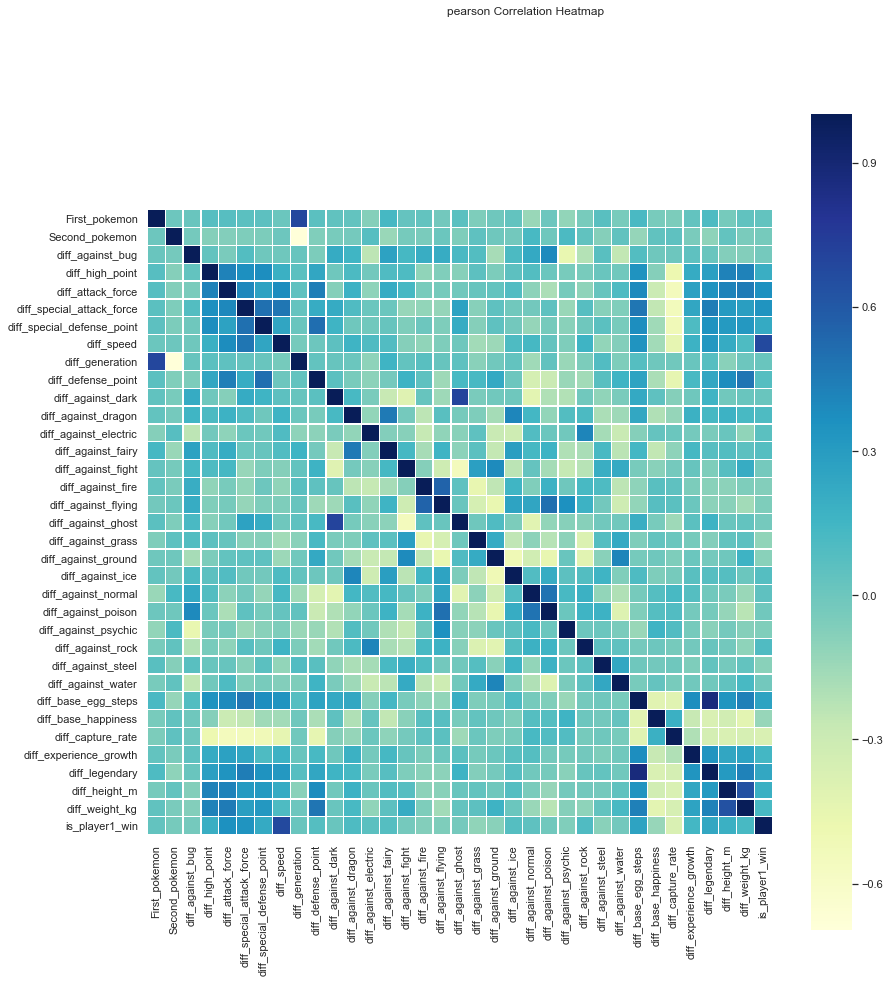

- [LOG] Output also save to output/descriptive/heatmap_pearson_pokemon_combat_pearson_report.png


In [7]:
validate_correlation(train_data, "pearson", 0.12)


kendall Correlation List with Mininum 0.12
diff_high_point               0.190717
diff_attack_force             0.296957
diff_special_attack_force     0.287635
diff_special_defense_point    0.198086
diff_speed                    0.605362
diff_base_egg_steps           0.180887
diff_capture_rate             0.304330
diff_experience_growth        0.136024
diff_legendary                0.231992
diff_height_m                 0.239559
diff_weight_kg                0.149692
is_player1_win                1.000000
Name: is_player1_win, dtype: float64


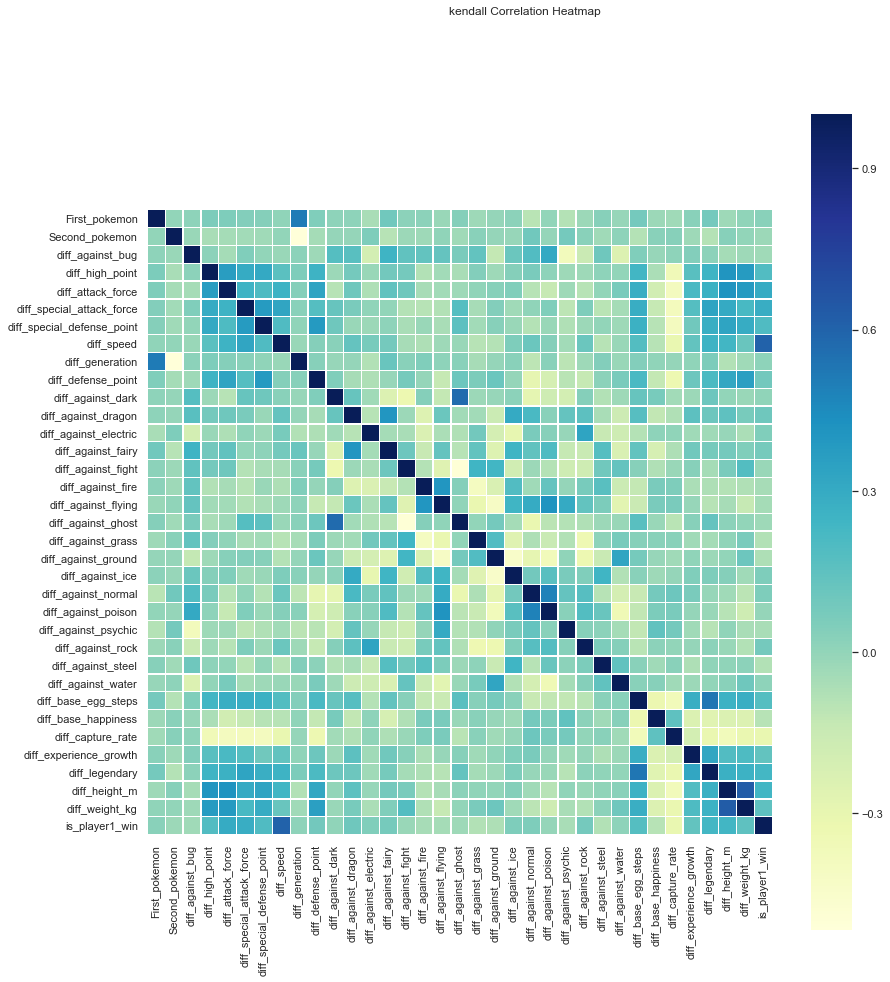

- [LOG] Output also save to output/descriptive/heatmap_kendall_pokemon_combat_kendall_report.png


In [8]:
validate_correlation(train_data, "kendall", 0.12)


spearman Correlation List with Mininum 0.12
diff_high_point               0.231587
diff_attack_force             0.361597
diff_special_attack_force     0.350050
diff_special_defense_point    0.240616
diff_speed                    0.737131
diff_base_egg_steps           0.207402
diff_capture_rate             0.366412
diff_experience_growth        0.157652
diff_legendary                0.236268
diff_height_m                 0.291344
diff_weight_kg                0.183285
is_player1_win                1.000000
Name: is_player1_win, dtype: float64


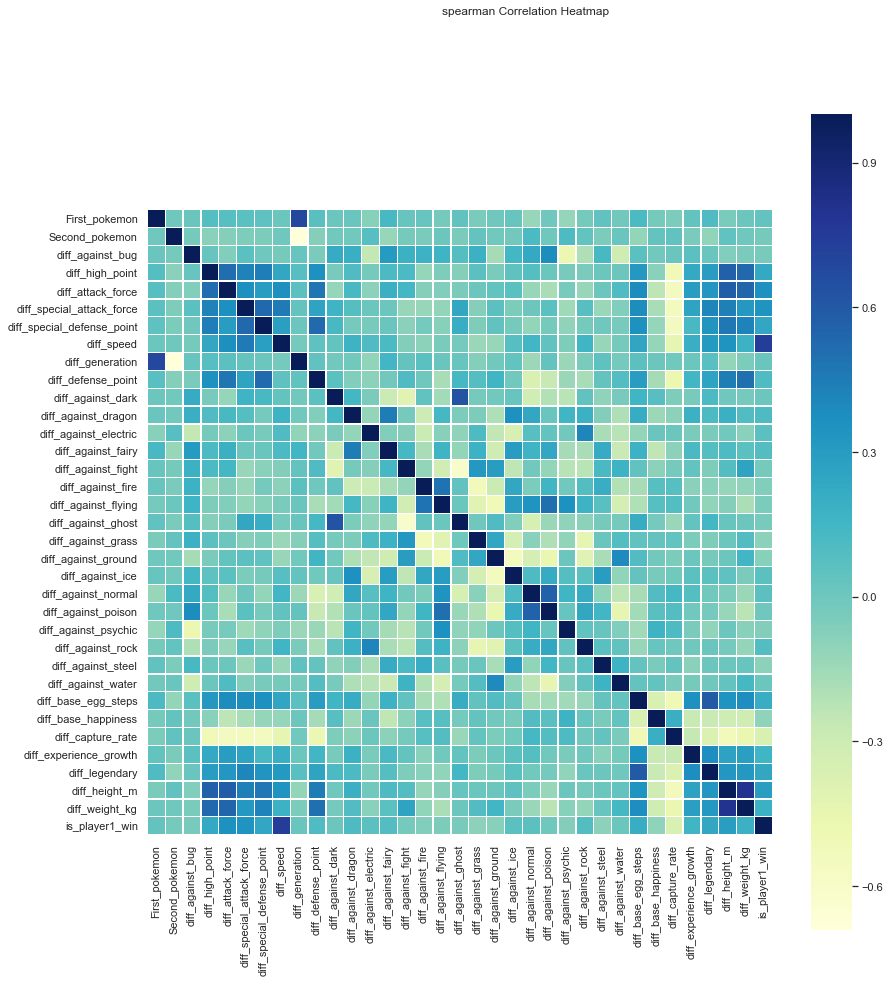

- [LOG] Output also save to output/descriptive/heatmap_spearman_pokemon_combat_spearman_report.png


In [9]:
validate_correlation(train_data, "spearman", 0.12)

##### 1.2.2 Pair Plot
Check Individual Comparison

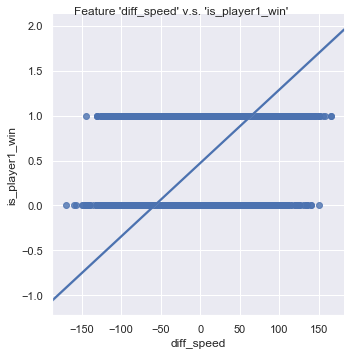

- [LOG] Output also save to output/descriptive/pairplot_diff_speed_report.png


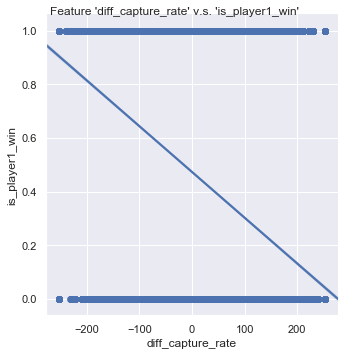

- [LOG] Output also save to output/descriptive/pairplot_diff_capture_rate_report.png


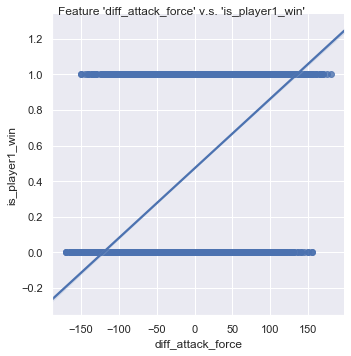

- [LOG] Output also save to output/descriptive/pairplot_diff_attack_force_report.png


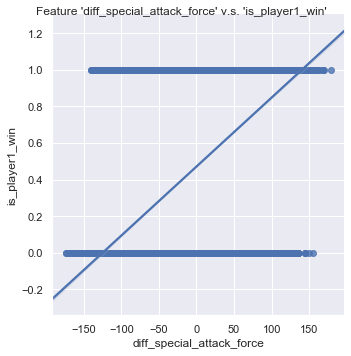

- [LOG] Output also save to output/descriptive/pairplot_diff_special_attack_force_report.png


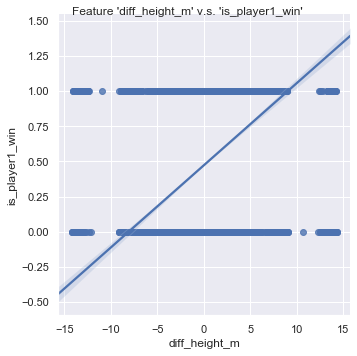

- [LOG] Output also save to output/descriptive/pairplot_diff_height_m_report.png


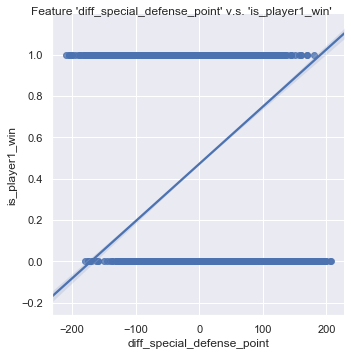

- [LOG] Output also save to output/descriptive/pairplot_diff_special_defense_point_report.png


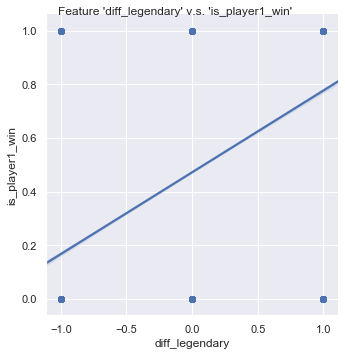

- [LOG] Output also save to output/descriptive/pairplot_diff_legendary_report.png


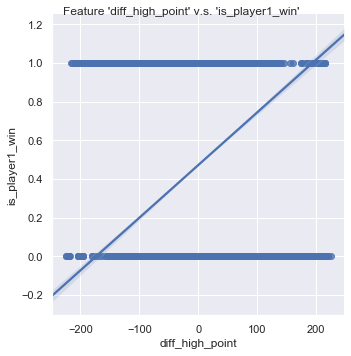

- [LOG] Output also save to output/descriptive/pairplot_diff_high_point_report.png


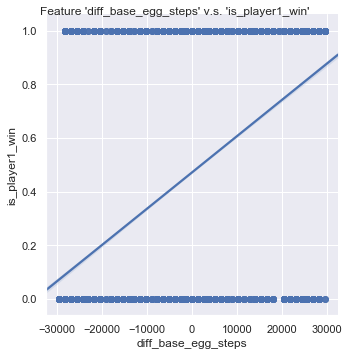

- [LOG] Output also save to output/descriptive/pairplot_diff_base_egg_steps_report.png


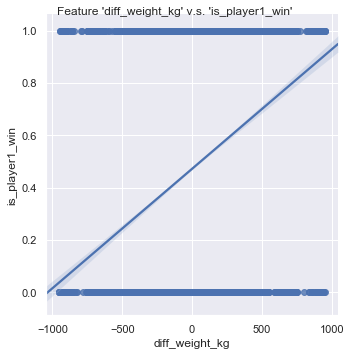

- [LOG] Output also save to output/descriptive/pairplot_diff_weight_kg_report.png


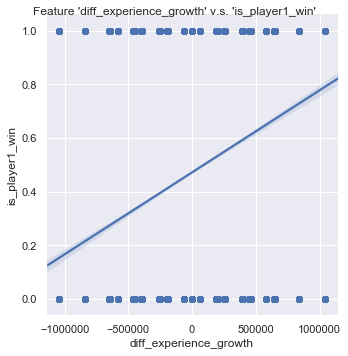

- [LOG] Output also save to output/descriptive/pairplot_diff_experience_growth_report.png


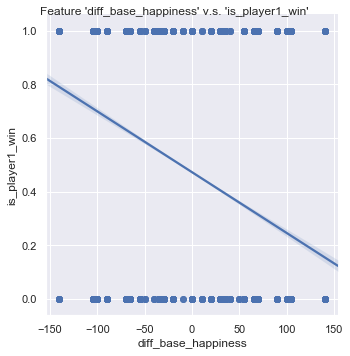

- [LOG] Output also save to output/descriptive/pairplot_diff_base_happiness_report.png


In [10]:
create_pair_plot(train_data, "diff_speed", "is_player1_win")
create_pair_plot(train_data, "diff_capture_rate", "is_player1_win")
create_pair_plot(train_data, "diff_attack_force", "is_player1_win")
create_pair_plot(train_data, "diff_special_attack_force", "is_player1_win")
create_pair_plot(train_data, "diff_height_m", "is_player1_win")
create_pair_plot(train_data, "diff_special_defense_point", "is_player1_win")
create_pair_plot(train_data, "diff_legendary", "is_player1_win")
create_pair_plot(train_data, "diff_high_point", "is_player1_win")
create_pair_plot(train_data, "diff_base_egg_steps", "is_player1_win")
create_pair_plot(train_data, "diff_weight_kg", "is_player1_win")
create_pair_plot(train_data, "diff_experience_growth", "is_player1_win")
create_pair_plot(train_data, "diff_base_happiness", "is_player1_win")

#### 1.3 Train Model
Train Model 
##### 1.3.1 Create Training and Test Dataset
Split Train and Test from Master_Combat.csv

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

def opt_StandardScaler(data):
    return StandardScaler().fit_transform(data)

def opt_MinMaxScaler(data):
    return MinMaxScaler().fit_transform(data)

def opt_RobustScaler(data):
    transformer = RobustScaler().fit(data)
    RobustScaler()
    return transformer.transform(data)

In [12]:
X = train_data.copy().drop(["is_player1_win"], axis=1)
Y = train_data.copy()["is_player1_win"]

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

def evaluate_classifier(name, xtrain, ytrain, xtest, ytest, ypred):
    print('- Accuracy:', accuracy_score(ypred, ytest))
    print('- ROC AUC:', roc_auc_score(ypred, ytest))
    print('- F1 macro:', f1_score(ypred, ytest, average='macro'))
    #print('- F1 micro:', f1_score(pred, ytest, average='micro'))
    #print('- F1 weighted:', f1_score(pred, ytest, average='weighted'))
    #print('- F1 None:', f1_score(pred, ytest, average=None))
    print('- Precision :', average_precision_score(ypred, ytest))
    
    # CONFUSION MATRIX
    mat = confusion_matrix(ytest, ypred)
    plot_confusion_matrix(conf_mat=mat, figsize=(3, 3), show_normed=True)
    filename = "output/" + name.lower() + "_model_confusion_matrix.png"
    plt.suptitle("CM {}".format(name), size = 10);
    plt.savefig(filename, dpi=100)  

def run_classifier(name, clf, xtrain, ytrain, xtest, ytest):
    print("\n\nClassifier: {} ".format(name))
    start_time = time.time()
    model = clf.fit(xtrain, ytrain)
    print("- Time: %s seconds" % (time.time() - start_time))
    pred = model.predict(xtest)
    
    evaluate_classifier(name, xtrain, ytrain, xtest, ytest, pred)

##### 1.3.2 Classifiers Evaluation
Evaluate Several Classifier performance



Classifier: std_gradient_boosting 
- Time: 4.840928316116333 seconds
- Accuracy: 0.9491333333333334
- ROC AUC: 0.9487597984179403
- F1 macro: 0.9490082224007471
- Precision : 0.9245371262090372


Classifier: std_random_forest 
- Time: 5.265151739120483 seconds
- Accuracy: 0.956
- ROC AUC: 0.955737007460543
- F1 macro: 0.9558763683295297
- Precision : 0.9327828429670293


Classifier: std_GaussianNB 
- Time: 0.02989649772644043 seconds
- Accuracy: 0.7842666666666667
- ROC AUC: 0.7835789795934074
- F1 macro: 0.7837055546552447
- Precision : 0.7074652417630656


Classifier: std_ann 
- Time: 94.47787523269653 seconds
- Accuracy: 0.9236
- ROC AUC: 0.9232885722994978
- F1 macro: 0.9233765660666503
- Precision : 0.8842039333476364


Classifier: std_svn 


C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


- Time: 9.781325101852417 seconds
- Accuracy: 0.5044666666666666
- ROC AUC: 0.508533670788313
- F1 macro: 0.5036048695652173
- Precision : 0.5739157725963907


Classifier: std_linearSVC 


C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


- Time: 222.1473035812378 seconds
- Accuracy: 0.6591333333333333
- ROC AUC: 0.6633883982650544
- F1 macro: 0.6499232193227813
- Precision : 0.4748946827581165


Classifier: std_logistic 
- Time: 155.52490496635437 seconds
- Accuracy: 0.7419333333333333
- ROC AUC: 0.7428878637896741
- F1 macro: 0.7393580975056038
- Precision : 0.6175294740551509


C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


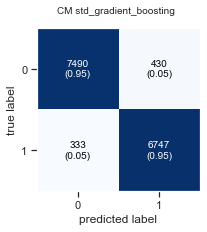

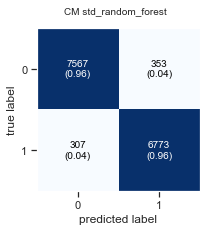

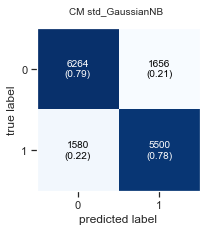

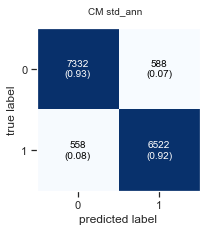

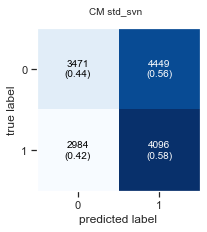

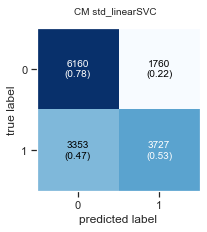

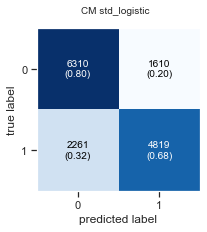

In [14]:
###########################################
# TEST 0
# SPLIT 7:3
###########################################

split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=2)
split.get_n_splits(X, Y)

for train_index, test_index in split.split(X, Y):
    xtrain = X.loc[train_index]
    ytrain = Y[train_index]
    xtest = X.loc[test_index]
    ytest = Y[test_index]

clf_dict = {
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'ann': MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
    'svn': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
    'linearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
    'logistic': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
}

for name, clf in clf_dict.items():
    run_classifier("std_"+name, clf, xtrain, ytrain, xtest, ytest)



Classifier: std_gradient_boosting 
- Time: 5.716959476470947 seconds
- Accuracy: 0.9492666666666667
- ROC AUC: 0.94889337950917
- F1 macro: 0.9491418836788579
- Precision : 0.9247360403486027


Classifier: std_random_forest 
- Time: 6.453651666641235 seconds
- Accuracy: 0.9559333333333333
- ROC AUC: 0.955654250940532
- F1 macro: 0.9558116939246865
- Precision : 0.9329620786968502


Classifier: std_GaussianNB 
- Time: 0.025931596755981445 seconds
- Accuracy: 0.7861333333333334
- ROC AUC: 0.7854518466075486
- F1 macro: 0.7855886943110746
- Precision : 0.7100419227335675


Classifier: std_ann 
- Time: 25.326751708984375 seconds
- Accuracy: 0.9521333333333334
- ROC AUC: 0.9521021923817795
- F1 macro: 0.9519695225080183
- Precision : 0.9236525152632203


Classifier: std_svn 


C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


- Time: 8.692433595657349 seconds
- Accuracy: 0.7854666666666666
- ROC AUC: 0.7957834727824501
- F1 macro: 0.7850377931793697
- Precision : 0.7949702834066678


Classifier: std_linearSVC 
- Time: 12.976106882095337 seconds
- Accuracy: 0.8815333333333333
- ROC AUC: 0.8813646740364054
- F1 macro: 0.881085028647935
- Precision : 0.8200564718285018


Classifier: std_logistic 
- Time: 0.27227282524108887 seconds
- Accuracy: 0.8847333333333334
- ROC AUC: 0.884624212564934
- F1 macro: 0.8842837241722867
- Precision : 0.8237548507900303


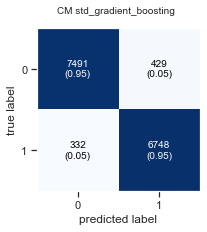

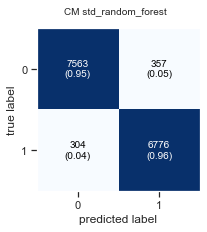

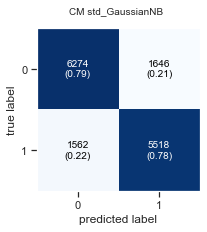

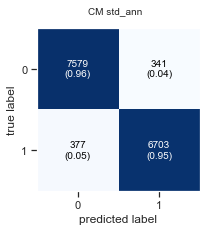

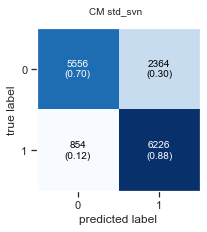

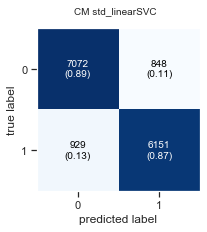

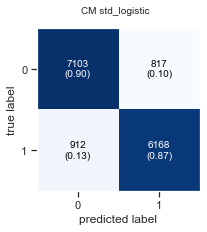

In [16]:
###########################################
# TEST 1
# SPLIT 7:3 WITH StandardScaler
###########################################

split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=2)
split.get_n_splits(X, Y)

for train_index, test_index in split.split(X, Y):
    xtrain = opt_StandardScaler(X.loc[train_index])
    ytrain = Y[train_index]
    xtest = opt_StandardScaler(X.loc[test_index])
    ytest = Y[test_index]

clf_dict = {
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'ann': MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
    'svn': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
    'linearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
    'logistic': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
}

for name, clf in clf_dict.items():
    run_classifier("std_"+name, clf, xtrain, ytrain, xtest, ytest)



Classifier: std_gradient_boosting 
- Time: 6.631623029708862 seconds
- Accuracy: 0.9464
- ROC AUC: 0.9460315170169448
- F1 macro: 0.946265664160401
- Precision : 0.9201767463300475


Classifier: std_random_forest 
- Time: 8.229032278060913 seconds
- Accuracy: 0.951
- ROC AUC: 0.9506188917250029
- F1 macro: 0.9508820678448957
- Precision : 0.9276541169809986


Classifier: std_GaussianNB 
- Time: 0.03390932083129883 seconds
- Accuracy: 0.7778
- ROC AUC: 0.777105967359712
- F1 macro: 0.7772475650512296
- Precision : 0.701217700557883


Classifier: std_ann 
- Time: 53.471858739852905 seconds
- Accuracy: 0.9536
- ROC AUC: 0.9537157020033732
- F1 macro: 0.9534278394885669
- Precision : 0.9244568377060598


Classifier: std_svn 


C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


- Time: 12.24154257774353 seconds
- Accuracy: 0.767
- ROC AUC: 0.7743481953352915
- F1 macro: 0.7667581655363547
- Precision : 0.7645011491053437


Classifier: std_linearSVC 
- Time: 18.87193489074707 seconds
- Accuracy: 0.878
- ROC AUC: 0.8779017414951286
- F1 macro: 0.8775107485322173
- Precision : 0.8139435470696345


Classifier: std_logistic 
- Time: 0.3561832904815674 seconds
- Accuracy: 0.8814
- ROC AUC: 0.8812882521758996
- F1 macro: 0.8809334065964338
- Precision : 0.8190048509392321


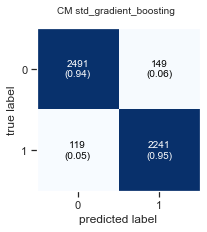

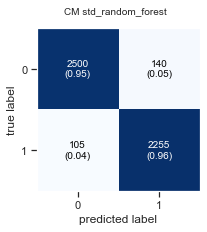

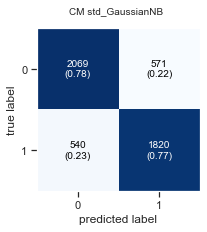

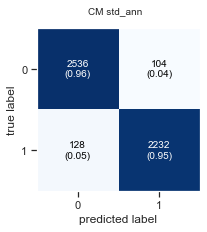

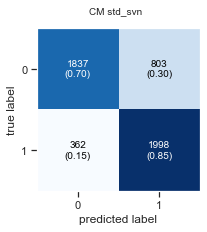

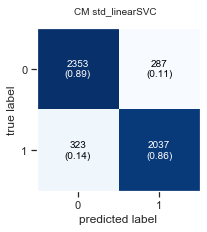

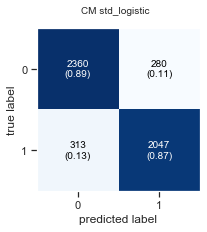

In [17]:
###########################################
# TEST 2
# SPLIT 9:1 WITH StandardScaler
###########################################

split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=2)
split.get_n_splits(X, Y)

for train_index, test_index in split.split(X, Y):
    xtrain = opt_StandardScaler(X.loc[train_index])
    ytrain = Y[train_index]
    xtest = opt_StandardScaler(X.loc[test_index])
    ytest = Y[test_index]

clf_dict = {
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'ann': MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
    'svn': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
    'linearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
    'logistic': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
}

for name, clf in clf_dict.items():
    run_classifier("std_"+name, clf, xtrain, ytrain, xtest, ytest)

(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)
(45000, 34)
(5000, 34)


Classifier: std_random_forest 
- Time: 20.191608428955078 seconds
- Accuracy: 0.705
- ROC AUC: 0.7043531517461605
- F1 macro: 0.703012787282778
- Precision : 0.5956237865515956


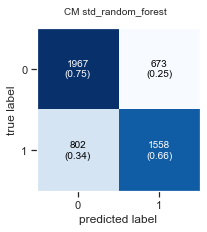

In [31]:
###########################################
# TEST 2.1
# SPLIT 9:1 WITH StandardScaler AND WITH PCA
###########################################

from sklearn.decomposition import PCA
pca = PCA(n_components=34)

def fit_pca(data):
    pca.fit(data)
    return pca.transform(data)

split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=2)
split.get_n_splits(X, Y)

for train_index, test_index in split.split(X, Y):
    xtrain = fit_pca(opt_StandardScaler(X.loc[train_index]))
    ytrain = Y[train_index]
    xtest = fit_pca(opt_StandardScaler(X.loc[test_index]))
    ytest = Y[test_index]

clf_dict = {
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'ann': MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
    'svn': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
    'linearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
    'logistic': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
}

for name, clf in clf_dict.items():
    run_classifier("std_"+name, clf, xtrain, ytrain, xtest, ytest)



Classifier: gradient_boosting 
- Time: 28.178081274032593 seconds
- Accuracy: 0.9518
- ROC AUC: 0.9514368757084704
- F1 macro: 0.951680550532672
- Precision : 0.9283877826024967


Classifier: random_forest 
- Time: 32.5533607006073 seconds
- Accuracy: 0.99176
- ROC AUC: 0.9916940090215758
- F1 macro: 0.9917348156526864
- Precision : 0.9871338539915105


Classifier: GaussianNB 
- Time: 0.44580721855163574 seconds
- Accuracy: 0.78978
- ROC AUC: 0.7891036024909228
- F1 macro: 0.7892218316718602
- Precision : 0.7132415683937208


Classifier: ann 
- Time: 211.28967142105103 seconds
- Accuracy: 0.97012
- ROC AUC: 0.9701745673117826
- F1 macro: 0.9700167574295677
- Precision : 0.9511101058844681


Classifier: svn 


C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Carlson\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Carlson\Anaconda3\lib\s

- Time: 71.7603497505188 seconds
- Accuracy: 0.75272
- ROC AUC: 0.7795555153152124
- F1 macro: 0.750020378474614
- Precision : 0.8186548250647121


Classifier: linearSVC 
- Time: 105.07368040084839 seconds
- Accuracy: 0.88318
- ROC AUC: 0.8830370372542049
- F1 macro: 0.8827329984067576
- Precision : 0.8220369661592867


Classifier: logistic 
- Time: 2.2303643226623535 seconds
- Accuracy: 0.88684
- ROC AUC: 0.8867012418747758
- F1 macro: 0.8864106560883405
- Precision : 0.8272389256518232


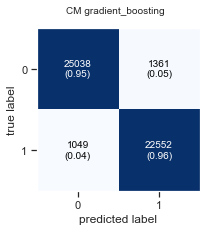

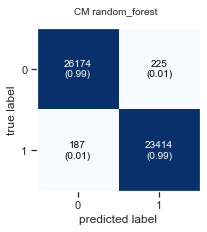

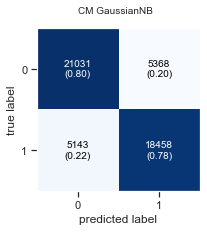

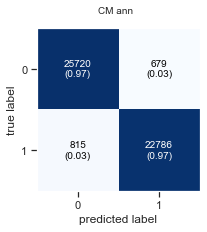

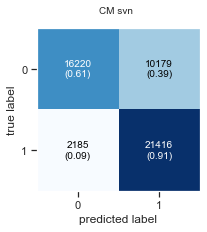

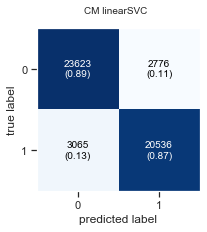

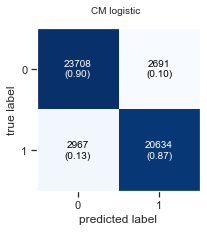

In [18]:
###########################################
# TEST 3
# 5 KFOLD WITH StandardScaler
###########################################

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=2)
_XTest = opt_StandardScaler(X)

clf_dict = {
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'ann': MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
    'svn': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
    'linearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
    'logistic': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
}

for name, clf in clf_dict.items():

    print("\n\nClassifier: {} ".format(name))
    start_time = time.time()
    
    for train_index, test_index in kf.split(X):
        xtrain = opt_StandardScaler(X.loc[train_index])
        ytrain = Y[train_index]
        model = clf.fit(xtrain, ytrain)
    
    print("- Time: %s seconds" % (time.time() - start_time))
    pred = model.predict(_XTest)

    evaluate_classifier(name, xtrain, ytrain, _XTest, Y, pred)


##### 1.3.3 Classifier Optimization


#### 1.2 Constructure Test Data

In [46]:
# LOAD DATA
test_data = pd.read_csv('dataset/tests.csv')

## APPEND FIRST AND SECOND PLAYERS STAT
test_data = structure_first_player_dataframe(test_data, pokemon_stat)
test_data = structure_second_player_dataframe(test_data, pokemon_stat)

## CHECK NULL VALUE PER COLUMNS
check_column_for_null(test_data)

test_data = test_data.drop(['first_pokemon_name'], axis=1)
test_data = test_data.drop(['first_pokemon_type_1'], axis=1)
test_data = test_data.drop(['first_pokedex_number'], axis=1)
test_data = test_data.drop(['first_classfication'], axis=1)
test_data = test_data.drop(['second_pokemon_name'], axis=1)
test_data = test_data.drop(['second_pokemon_type_1'], axis=1)
test_data = test_data.drop(['second_pokedex_number'], axis=1)
test_data = test_data.drop(['second_classfication'], axis=1)


# MERGE
test_data = create_new_diff_column("against_bug", test_data)
test_data = create_new_diff_column("high_point", test_data)
test_data = create_new_diff_column("attack_force", test_data)
test_data = create_new_diff_column("special_attack_force", test_data)
test_data = create_new_diff_column("special_defense_point", test_data)
test_data = create_new_diff_column("speed", test_data)
test_data = create_new_diff_column("generation", test_data)
test_data = create_new_diff_column("defense_point", test_data)
test_data = create_new_diff_column("against_dark", test_data)
test_data = create_new_diff_column("against_dragon", test_data)
test_data = create_new_diff_column("against_electric", test_data)
test_data = create_new_diff_column("against_fairy", test_data)
test_data = create_new_diff_column("against_fight", test_data)
test_data = create_new_diff_column("against_fire", test_data)
test_data = create_new_diff_column("against_flying", test_data)
test_data = create_new_diff_column("against_ghost", test_data)
test_data = create_new_diff_column("against_grass", test_data)
test_data = create_new_diff_column("against_ground", test_data)
test_data = create_new_diff_column("against_ice", test_data)
test_data = create_new_diff_column("against_normal", test_data)
test_data = create_new_diff_column("against_poison", test_data)
test_data = create_new_diff_column("against_psychic", test_data)
test_data = create_new_diff_column("against_rock", test_data)
test_data = create_new_diff_column("against_steel", test_data)
test_data = create_new_diff_column("against_water", test_data)
test_data = create_new_diff_column("base_egg_steps", test_data)
test_data = create_new_diff_column("base_happiness", test_data)
test_data = create_new_diff_column("capture_rate", test_data)
test_data = create_new_diff_column("experience_growth", test_data)
test_data = create_new_diff_column("legendary", test_data)
test_data = create_new_diff_column("height_m", test_data)
test_data = create_new_diff_column("weight_kg", test_data)




test_data.to_csv('output/master_test_v1.0.csv', index=False)




- [LOG] No Null Value


In [47]:
###########################################
# TEST 5
# 5 KFOLD WITH StandardScaler
###########################################

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=2)
    
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling')
#clf = RandomForestClassifier(n_estimators=100, random_state=0)

for train_index, test_index in kf.split(X):
    xtrain = opt_StandardScaler(X.loc[train_index])
    ytrain = Y[train_index]
    model = clf.fit(xtrain, ytrain)
    
pred = model.predict(test_data)



In [49]:
print(pred)

[ True False False ...  True False False]
